## Analysis of Titanic data

The Titanic data set contains information about passengers aboard the 1912 Titanic ship that met with disaster on its maiden voyage from England to America. It records the survival status of each of 891 passengers on board along with their defining characteristics: name, age, gender, cabin identifier, class travelled, port of embarkation, ticket identifier, fare and whether they had any parents, children, partners or siblings on board. The objective of this analysis is to investigate questions that we could ask of this data set, elicit answers using Python to manipulate and query this data, and present the analysis via visualisation and textual commentary.

I analyse here the most important dependent variable: survival, in relation to the following independent variables: age, gender, class of travel and port of embarkation.  

#### Here are some investigative questions that pique my interest!
1. How many males and females were on board? What percentage of survivors were male vs. female?
2. What impact did a passenger's class of travel have on their survival?
3. What was the number of survivors by embarkation location?
4. How many children vs. adults survived?
5. Compare characteristics of survivors vs. non-survivors. For example, were their more single people that survived? Or were there more that had some family on board?

## Load data from csv

In [1]:
import pandas as pd
import numpy as np

df_master = pd.read_csv('titanic-data.csv', index_col='PassengerId')

## Explore the data

In [2]:
df_master.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


An initial exploration of the data reveals the following essential facts:
1. There are 77 missing values for Age. This means that we do not know the "adult" or "child" status for these records, and so we'll want to tag these as "U" for "Unknown".
2. A greater number of passengers died than survived.
3. The youngest passenger was less than 6 months old, and the oldest was 80.
4. Half the passengers were below 28 years of age, and three-quarters were below 38! This is a really young demographic (ignoring passengers with unrecorded ages, of course).

## Fix data types, fill in missing values and add new derived columns for analysis

#### I decided here to fill in -1 for Age values where they were null. This is done because around 20% of records do not contain age data and ignoring these records completely could lead to skewed and less accurate analysis. However, for age-based analysis, these records will be removed.  

In [3]:
# This function takes in a data row and returns the adult status of an individual based on their age.
def translateAge(row):
    if row['Age'] > 18.0:
        return 'Adult'
    elif row['Age'] > 0.0:
        return 'Child' 
    else:
        return 'Unknown'

# This function takes in a data row and determines if the individual had any family on board based on whether or not they had a sibling, spouse, parent or child on board.
def translateFamilyStatus(row):
    if (row['SibSp'] > 0) or (row['Parch'] > 0):
        return 'Family'
    else:
        return 'Alone'    

df_master['Survived'] = pd.to_numeric(df_master['Survived'], errors='coerce')
df_master['Pclass'] = pd.to_numeric(df_master['Pclass'], errors='coerce')
df_master['Age'] = pd.to_numeric(df_master['Age'], errors='coerce')

df_master['Age'].fillna(-1, inplace=True)

df_master['SibSp'] = pd.to_numeric(df_master['SibSp'], errors='coerce')
df_master['Parch'] = pd.to_numeric(df_master['Parch'], errors='coerce')

df_master['Embarked'].replace('S', 'Southampton', inplace=True)
df_master['Embarked'].replace('C', 'Cherbourg', inplace=True)
df_master['Embarked'].replace('Q', 'Queenstown', inplace=True)

# Add a new column to designate each passenger as adult, child or unknown if Age is unspecified. 
df_master['AdultorChild'] = df_master.apply(translateAge, axis=1)
# Add a new column to designate if a passenger was travelling alone or with family
df_master['AloneorFamily'] = df_master.apply(translateFamilyStatus, axis=1)
# Split the Name column into Firstname and Lastname. We are mainly interested in the Lastname 
d2 = pd.DataFrame(df_master['Name'].str.split(",").tolist(), columns="Lastname Firstname".split())
df_master['Lastname'] = d2["Lastname"]
df_master['Firstname'] = d2["Firstname"]

### How many males and females were on board? What percentage of survivors were male vs. female?

In [4]:
total_records = len(df_master)
male = len(df_master[(df_master['Sex']== 'male')])
female = len(df_master[(df_master['Sex']== 'female')])
print ("Total males on board = " + str(male))
print ("Total females on board = " + str(female))

df_survivors = df_master[(df_master['Survived'] == 1)]
total_survivors = len(df_survivors)
print ("Total survivors = " + str(total_survivors))
male_survivors = len(df_survivors[(df_survivors['Sex']== 'male')])
print ("Male survivors = " + str(male_survivors))
female_survivors = len(df_survivors[(df_survivors['Sex']== 'female')])
print ("Femle survivors = " + str(female_survivors))

print ("% male survivors = " + str(round((male_survivors/total_survivors) * 100,2)))
print ("% female survivors = " + str(round((female_survivors/total_survivors) * 100,2)))


Total males on board = 577
Total females on board = 314
Total survivors = 342
Male survivors = 109
Femle survivors = 233
% male survivors = 31.87
% female survivors = 68.13


#### These numbers reveal that the survival rate for males was low! In fact, one could use gender as a strong predictor for survival. One hypothesis is that female passengers travelling either alone or with family were put on to lifeboats first. With the passage of time, the survival situation became increasingly difficult, resulting in male passengers finding it increasingly difficult to escape.  Another hypothesis could be that males and females were placed in different classes or cabins and therefore, by virtue of the class/cabin location and proximity to the available lifeboats, they were less likely to survive. Let us first examine the impact of a passenger's class of travel on their survival, and then investigate whether there were more males than females in any particular class. 

In [5]:
# This function takes a list of fields to use to aggregate the count of passengers, survivors and percentage of survivors
def survivorgrouping(fields):
    df_totalbygroup = df_master.groupby(fields)['Survived'].agg(['count']).rename(columns=dict(count='Total_Numbers'))
    df_survivorsbygroup = df_survivors.groupby(fields)['Survived'].agg(['count']).rename(columns=dict(count='Total_Survivors'))
    df_merged = pd.concat([df_totalbygroup, df_survivorsbygroup], axis=1)
    df_merged['% survivors'] = round((df_merged['Total_Survivors']/df_merged['Total_Numbers']) * 100,2)
    return df_merged

### What impact did a passenger's class of travel have on their survival?

In [6]:
survivorgrouping('Pclass')

,Total_Numbers,Total_Survivors,% survivors
Pclass,,,
1,216,136,62.96
2,184,87,47.28
3,491,119,24.24


#### These numbers reveal that the class of travel did indeed impact survival. Not even a quarter of the number of passengers travelling 3rd class survived. Less than half of passengers travelling 2nd class survived. And more than half of passengers travelling 1st class survived. Presumably, 3rd class passengers were lower down and closer to the water and so their cabins flooded first? 2nd class passengers were a deck above and 1st class passengers were high up top and had more time than those down below, to prepare escape. They were also more likely to have had prioritity access to lifeboats given they may be more wealthy and influential.

#### Let us now see if there were more males than females in 3rd class. Also, were there more females travelling 1st class?

### Were their more males than females in 3rd class?

In [7]:
survivorgrouping(['Pclass','Sex'])

Total_Numbers  Total_Survivors  % survivors
Pclass Sex                                                
1      female             94               91        96.81
       male              122               45        36.89
2      female             76               70        92.11
       male              108               17        15.74
3      female            144               72        50.00
       male              347               47        13.54

#### From previous analyses, we saw that males were less likely to survive than females. We also saw that passengers travelling 3rd class were less likely to survive than passengers travelling in higher classes. Now, the above data shows that there were more than double the number of males than females travelling 3rd class and this could be one possible factor in explaining why fewer males survived.  Another reason stated previously could be that female passengers were more likely than male passengers to be prioritised for lifeboats.

#### Interestingly we observe that there were fewer females travelling 1st class than in 3rd class. Yet, overall, more females survived. This tells us that while class of travel is a strong predictor of survival, gender is a stronger predictor. In each class of travel, more females and males survived.  

##### The graph below shows how the relationship between class of travel and survival changes from 1st to 3rd class, for males and females.

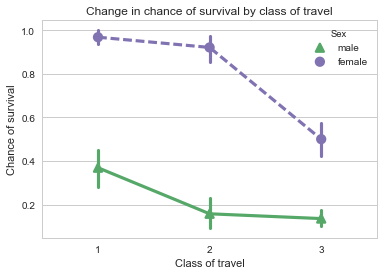

In [18]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

g = sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=df_master,
              palette={"male": "g", "female": "m"},
              markers=["^", "o"], linestyles=["-", "--"])

g.set_ylabel('Chance of survival')
g.set_xlabel('Class of travel')
g.set_title("Change in chance of survival by class of travel")

#### The above plot provides confirmation that males in general had less than 50% chance of survival. Males in 1st class had double the chance of survival than males in 2nd class. But then, there was only a small decrease in survival chance for male passengers travelling 3rd class vs. those travelling 2nd class, so 3rd class male passengers were not much worse off!

#### Female travellers in 1st class were the luckiest of all. More than 95% females travelling 1st class survived. 2nd class female passengers also had a greater than 85% survival rate, however 3rd class female passengers had around a 50% survival rate. 

#### Across males and females in general, 3rd class passengers were the most unfortunate in their chances of survival, although females here were around 3 times more likely than males to have survived. 

### What was the number of survivors by embarkation location?

In [9]:
survivorgrouping('Embarked')

,Total_Numbers,Total_Survivors,% survivors
Embarked,,,
Cherbourg,168,93,55.36
Queenstown,77,30,38.96
Southampton,644,217,33.70


#### Cherbourg had the largest percentage of survivors. Southampton had the largest number of passengers on-boarding but the fewest percent survivors. We know that Southampton was the point of origin for the Titanic and it then stopped at Cherbourg in France followed by Queenstown, Ireland. 

#### Given we know that class of travel and gender are already strong predictors of survival, can we find a relationship between these and the port of embarkation?

In [19]:
survivorgrouping(['Embarked','Pclass','Sex'])

Total_Numbers  Total_Survivors  % survivors
Embarked    Pclass Sex                                                
Cherbourg   1      female             43             42.0        97.67
                   male               42             17.0        40.48
            2      female              7              7.0       100.00
                   male               10              2.0        20.00
            3      female             23             15.0        65.22
                   male               43             10.0        23.26
Queenstown  1      female              1              1.0       100.00
                   male                1              NaN          NaN
            2      female              2              2.0       100.00
                   male                1              NaN          NaN
            3      female             33             24.0        72.73
                   male               39              3.0         7.69
Southampton 1      female             48             46.0        95.83
                   male               79             28.0        35.44
            2      female             67             61.0        91.04
                   male               97             15.0        15.46
            3      female             88             33.0        37.50
                   male              265             34.0        12.83

#### Analysing the above data reaffirms that across all three embarkation locations, 3rd class male passengers were still the least likely to survive. It does not seem to be the case that there was an skewed distribution of passengers in any class by embarkation location.

### How many adults vs. children were on board? What percentage of survivors were adult vs. children?

In [10]:
survivorgrouping('AdultorChild')

,Total_Numbers,Total_Survivors,% survivors
AdultorChild,,,
Adult,575,220,38.26
Child,139,70,50.36
Unknown,177,52,29.38


#### The above numbers show that about 15% of the passengers were known with certainty to be minors (139/891 ~ 15%). Around 50% of them survived. The survival rate for adults was around 38%. Understandably, given the limited availability of life-boats, one would think that the safe escape of children was prioritised over that of adults. The graph below shows the count of survivors binned by age. Here, I remove those records where age information was not present (previously replaced by -1 in the master data set)

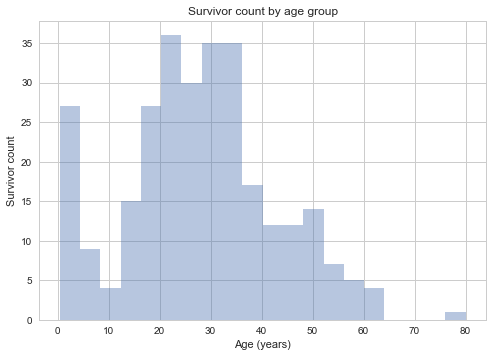

In [36]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

df_survivorsAgePresent = df_survivors[(df_survivors['Age'] > 0)]
x = pd.Series(df_survivorsAgePresent['Age'], name="Age (years)")
g = sns.distplot(x, bins=20, kde=False)
g.set_ylabel('Survivor count')
g.set_title('Survivor count by age group')

### How many survivors were travelling alone vs. family and how many of these were male vs. female?  

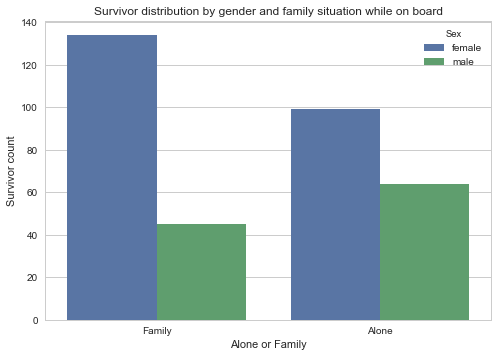

In [22]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
x = pd.Series(df_survivors['AloneorFamily'], name="Alone or Family")
g = sns.countplot(x, hue='Sex', data=df_survivors)
g.set_ylabel('Survivor count')
g.set_title('Survivor distribution by gender and family situation while on board')

#### We see above that of all survivors, a greater number were travelling with family. Of these, more than 3 times were females than males. 

### Conclusions

My aim with the data set was to investigate the relation between the independent data we have on Titanic passengers and their survival, and understand what, if any, factors were strong predictors of survival. 

The analysis project first undertook to explore the dataset - the fields, descriptions, meaning, record count and identified any discrepancies. A brief data wrangling phase cleaned up missing data for later use. There was some missing age data but other data was fully provided. The first step was to compare the count of survivors vs. those who perished and I found that more people died than survived. I then sought to divide the survivors by gender and found that around 68% of females and only 32% males survived. Given the nature of society and the higher regard for the safety of women and family at the time, it does seem logical that men in general would have sacrificed their own safety to protect women. 

I then delved to analyse these numbers by passengers' class of travel. It came out very strongly that passengers travelling 3rd class with or without gender considerations, were less likely to survive than passengers travelling 1st or 2nd class. This would make sense considering 3rd class cabins were closer to the water and were likely to have been flooded in first. By extension of these two analyses, I hypothesised that 1st class female passengers had close to a 100% chance of survival, and this is again clearly revealed by the data. By extension, 3rd class male passengers were least likely to survive and had a survival chance of merely 13.5%. A further analysis revealed that males and females travelling with any family on board were more likely to survive than passengers travelling alone. Again, this seems natural given greater solidarity with families, especially those travelling with siblings, spouses, parents or young children on board. 

I also wanted to investigate if passengers from any particular port of embarkation had higher survival rates. The data shows that this was not true. It was also not the case that passengers from any particular port were placed in a particular class or were of a particular gender.

An interesting fact is that half the passengers on board the Titanic were below 28 years of age, and three-quarters were below 38! This is a really young demographic (ignoring passengers with unrecorded ages, of course). Consequently, the highest number f survivors was between 20 and 35 years.

Below are discussed some limitations of the analysis carried out and potential directions for further analysis.

### Limitations

1. The analysis is only as good as the quality of data!
2. Age records are missing for 177 passengers which is nearly 20% of the total data provided. Accurate records of these could lead to better/more accurate/interesting insights. I did not have solid background information to make any reasonable assumptions about age, so decided simply to replace missing age values with -1. Other than age binning, no significant analysis was done using age.
3. This analysis did not delve deeper into separating spouse from sibling, or parent from child.
4. It did not separate family units by common last name
5. A deeper analysis, not undertaken here, would research the structure and organisation of cabins and lifeboats on the ship and provide greater understanding of the survival data.  

### Food for thought for further analysis

#### Further analysis of the Titanic data set could yield further insight. Here are some thoughts:
1. Identify each family (by a common last name would be a good starting point). Then for each family, identify how many members survived. How many children were orphaned, how many were surviving spouses and siblings? 
2. Build a predictive model for the strongest predictors of survival. We have already seen here that gender and class of travel were strong factors. A full supervised learning model could be based on the data given here and used to predict survival on unseen test data.
3. Are there any insights to be gleaned based on fare? It seems logical that fare is based on class of travel and cabin but could this be a predictor for survival in its own right?

### References:
1. http://stackoverflow.com
2. http://www.kaggle.com
3. http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.split.html
4. http://seaborn.pydata.org/generated/seaborn.distplot.html
5. http://seaborn.pydata.org/tutorial/categorical.html
6. http://www.ultimatetitanic.com/the-voyage/